<h1><h1>Pre-trained-Models with PyTorch </h1>


We will be using the pre-trained resnet18 image detection model.
We wiil be doing the following with the pre-tranined model.
<ul>
<li>change the output layer</li>
<li> train the model</li> 
<li>  identify  several  misclassified samples</li> 
 </ul>

<h2 id="download_data">Download Data</h2>


Download the dataset and unzip the files in your data directory:


In [1]:
!wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip 

--2023-12-24 11:52:41--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Positive_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2598656062 (2.4G) [application/zip]
Saving to: ‘Positive_tensors.zip’

Positive_tensors.zi 100%[===================>]   2.42G  12.3MB/s    in 2m 21s  

2023-12-24 11:55:03 (17.6 MB/s) - ‘Positive_tensors.zip’ saved [2598656062/2598656062]



In [2]:
!unzip -q Positive_tensors.zip 

In [3]:
! wget https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
!unzip -q Negative_tensors.zip

--2023-12-24 11:56:43--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0321EN/data/images/Negative_tensors.zip
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2111408108 (2.0G) [application/zip]
Saving to: ‘Negative_tensors.zip’

Negative_tensors.zi 100%[===================>]   1.97G  14.8MB/s    in 2m 36s  

2023-12-24 11:59:20 (12.9 MB/s) - ‘Negative_tensors.zip’ saved [2111408108/2111408108]



We will install torchvision:


In [4]:
!pip install torchvision

<h2 id="auxiliary">Imports and Auxiliary Functions</h2>


The following are the libraries we are going to use. The <code>torch.manual_seed()</code> is for forcing the random function to give the same number every time we try to recompile it.


In [5]:
# These are the libraries will be used for this lab.
import torchvision.models as models
from PIL import Image
import pandas
from torchvision import transforms
import torch.nn as nn
import time
import torch 
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py
import os
import glob
torch.manual_seed(0)

In [6]:
from matplotlib.pyplot import imshow
import matplotlib.pylab as plt
from PIL import Image
import pandas as pd
import os

<!--Empty Space for separating topics-->


<h2 id="data_class">Dataset Class</h2>


We are going to convert the group of images in into an list with even indices with positive images and odd indices with negative image, we are going to use tensors instead of jpeg images. Therefor for each iteration, you will skip the reshape step, conversion step to tensors and normalization step.


In [7]:
# Create your own dataset object

class Dataset(Dataset):

    # Constructor
    def __init__(self,transform=None,train=True):
        directory="/home/wsuser/work"
        positive="Positive_tensors"
        negative='Negative_tensors'

        positive_file_path=os.path.join(directory,positive)
        negative_file_path=os.path.join(directory,negative)
        positive_files=[os.path.join(positive_file_path,file) for file in os.listdir(positive_file_path) if file.endswith(".pt")]
        negative_files=[os.path.join(negative_file_path,file) for file in os.listdir(negative_file_path) if file.endswith(".pt")]
        number_of_samples=len(positive_files)+len(negative_files)
        self.all_files=[None]*number_of_samples
        self.all_files[::2]=positive_files
        self.all_files[1::2]=negative_files 
        # The transform is goint to be used on image
        self.transform = transform
        #torch.LongTensor
        self.Y=torch.zeros([number_of_samples]).type(torch.LongTensor)
        self.Y[::2]=1
        self.Y[1::2]=0
        
        if train:
            self.all_files=self.all_files[0:30000]
            self.Y=self.Y[0:30000]
            self.len=len(self.all_files)
        else:
            self.all_files=self.all_files[30000:]
            self.Y=self.Y[30000:]
            self.len=len(self.all_files)     
       
    # Get the length
    def __len__(self):
        return self.len
    
    # Getter
    def __getitem__(self, idx):
               
        image=torch.load(self.all_files[idx])
        y=self.Y[idx]
                  
        # If there is any transform method, apply it onto the image
        if self.transform:
            image = self.transform(image)

        return image, y
    
print("done")

done


We create two dataset objects, one for the training data and one for the validation data.


In [8]:
train_dataset = Dataset(train=True)
validation_dataset = Dataset(train=False)
print("done")

done


<b>Prepare a pre-trained resnet18 model :</b>


<b>Step 1</b>: Load the pre-trained model <code>resnet18</code> Set the parameter <code>pretrained</code> to true:


In [11]:
model = models.resnet18(pretrained=True)

<b>Step 2</b>: Set the attribute <code>requires_grad</code> to <code>False</code>. As a result, the parameters will not be affected by training.


In [13]:
for param in model.parameters():
    param.requires_grad = False

<code>resnet18</code> is used to classify 1000 different objects; as a result, the last layer has 1000 outputs.  The 512 inputs come from the fact that the previously hidden layer has 512 outputs. 


<b>Step 3</b>: Replace the output layer <code>model.fc</code> of the neural network with a <code>nn.Linear</code> object, to classify 2 different classes. For the parameters <code>in_features </code> remember the last hidden layer has 512 neurons.


In [14]:
model.fc = nn.Linear(in_features=512, out_features=2)


Print out the model in order.<br>


In [15]:
# Print the modified ResNet18 model
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<b>Train the Model:</b>

<b>Step 1</b>: Create a cross entropy criterion function 


In [16]:
criterion = nn.CrossEntropyLoss()

<b>Step 2</b>: Create a training loader and validation loader object, the batch size should have 100 samples each.


In [17]:
batch_size = 100

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

<b>Step 3</b>: Use the following optimizer to minimize the loss 


In [18]:
optimizer = torch.optim.Adam([parameters for parameters in model.parameters() if parameters.requires_grad], lr=0.001)

<!--Empty Space for separating topics-->


**Calculate the accuracy on the validation data for one epoch; this should take about 45 minutes. Make sure you calculate the accuracy on the validation data.**
<br>The tqdm module is used to make a progress bar to visualize training and validation progress.

In [20]:
from tqdm import tqdm

n_epochs = 1
loss_list = []
accuracy_list = []
correct = 0
N_test = len(validation_dataset)
N_train = len(train_dataset)
start_time = time.time()

# n_epochs
Loss = 0
start_time = time.time()

for epoch in range(n_epochs):
    # Create a progress bar for training
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{n_epochs}', leave=False)
    
    for x, y in train_bar:
        model.train() 
        # Clear gradient
        optimizer.zero_grad()
     
        # Make a prediction 
        z = model(x)
   
        # Calculate loss 
        loss = criterion(z, y)
    
        # Calculate gradients of parameters 
        loss.backward()
        
        # Update parameters 
        optimizer.step()
        
        loss_list.append(loss.data)
        
        # Update the progress bar
        train_bar.set_postfix({'Training Loss': loss.item()})
    
    correct = 0
    # Create a progress bar for validation
    validation_bar = tqdm(validation_loader, desc=f'Validation', leave=False)
    
    for x_test, y_test in validation_bar:
        # Set model to eval 
        model.eval()
       
        # Make a prediction 
        z = model(x_test)
       
        # Find max 
        _, yhat = torch.max(z.data, 1)
       
        # Calculate misclassified samples in mini-batch 
        correct += (yhat == y_test).sum().item()
        
        # Update the progress bar
        validation_bar.set_postfix({'Validation Accuracy': correct / N_test})
    
    accuracy = correct / N_test
    accuracy_list.append(accuracy)

total_time = time.time() - start_time
print("Training Duration: {:.2f} seconds".format(total_time))


Training Duration: 3693.54 seconds


<b>Print out the Accuracy and plot the loss stored in the list <code>loss_list</code>.</b>


In [21]:
accuracy

0.9923

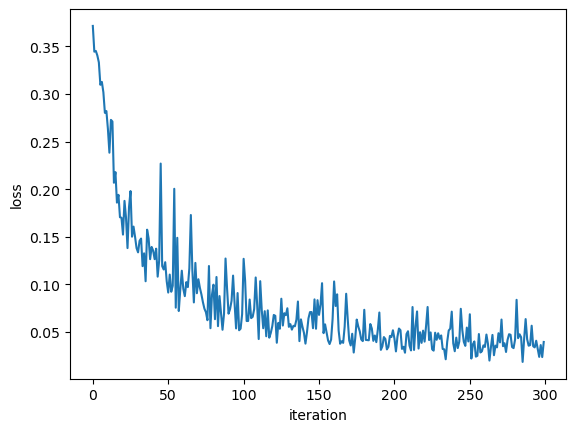

In [22]:
plt.plot(loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.show()


<b>Find the misclassified samples :</b>

<b>Identifying the first four misclassified samples using the validation data:</b>


In [24]:
# Ensure the model is in evaluation mode
model.eval()

misclassified_count = 0
max_misclassified = 4  # Number of misclassified samples to identify

# Lists to store misclassified sample information
misclassified_samples = []

# Create a progress bar
validation_bar = tqdm(validation_loader, desc='Identifying Misclassified Samples', leave=False)

# Loop through the validation data
for i, (x_val, y_val) in enumerate(validation_bar):
    # Make predictions
    with torch.no_grad():
        outputs = model(x_val)
    
    # Find the predicted labels
    _, predicted = torch.max(outputs.data, 1)
    
    # Check for misclassifications
    misclassified_idx = (predicted != y_val).nonzero()
    
    # Identify and print the first four misclassified samples
    for idx in misclassified_idx:
        if misclassified_count < max_misclassified:
            misclassified_samples.append({
                'Sample Index': i * batch_size + idx.item(),
                'Predicted Value': predicted[idx].item(),
                'Actual Value': y_val[idx].item()
            })
            misclassified_count += 1
        else:
            break

    # Update the progress bar
    validation_bar.set_postfix({'Misclassified Count': misclassified_count})

    # Break the loop if we have found the required number of misclassified samples
    if misclassified_count >= max_misclassified:
        break

# Close the progress bar
validation_bar.close()

# Print the information for the misclassified samples
for sample_info in misclassified_samples:
    print(f"Sample{sample_info['Sample Index']} predicted value: tensor([{sample_info['Predicted Value']}])  actual value: tensor([{sample_info['Actual Value']}])")

Sample80 predicted value: tensor([0])  actual value: tensor([1])
Sample111 predicted value: tensor([1])  actual value: tensor([0])
Sample334 predicted value: tensor([0])  actual value: tensor([1])
Sample419 predicted value: tensor([1])  actual value: tensor([0])
